In [1]:
cd ../python

/Users/ashkanaleali/w/Trader/python


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime

from arctic import Arctic
import quandl

from utilities import *

In [3]:
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')

In [4]:
%load_ext autoreload
%autoreload 2

In [10]:
store = Arctic('localhost')

In [13]:
# Create the library - defaults to VersionStore
store.initialize_library('NASDAQ')

# Access the library
library = store['NASDAQ']

# Load some data - maybe from Quandl
aapl = quandl.get("WIKI/AAPL", authtoken="ZUXueWCTcmEZRV7CAcBw")

# Store the data in the library
library.write('AAPL', aapl, metadata={'source': 'Quandl'})

VersionedItem(symbol=AAPL,library=arctic.NASDAQ,data=<type 'NoneType'>,version=1,metadata={'source': 'Quandl'}

In [14]:
item = library.read('AAPL')
aapl = item.data
metadata = item.metadata

In [30]:
aapl = stock_data_quandl('AAPL')

# Close

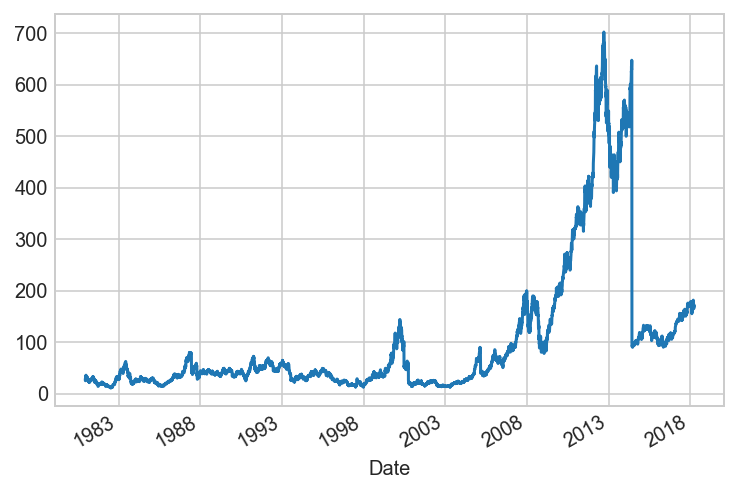

In [35]:
aapl['Close'].plot()

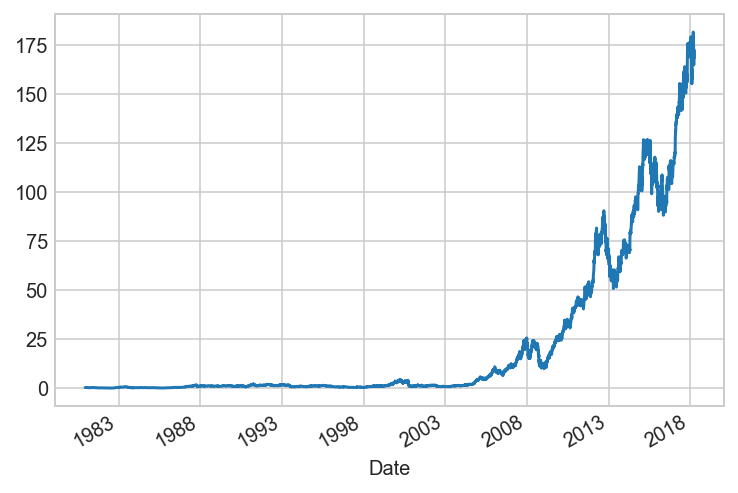

In [36]:
aapl['Adj. Close'].plot()

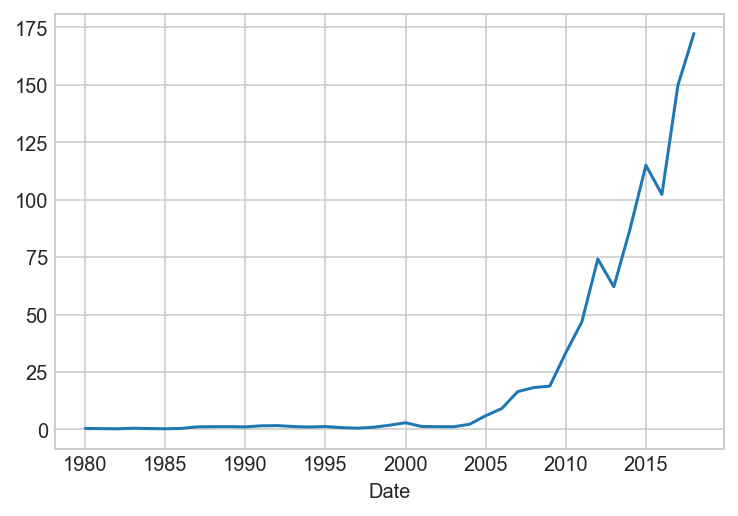

In [38]:
aapl.resample('Y')['Adj. Close'].mean().plot()

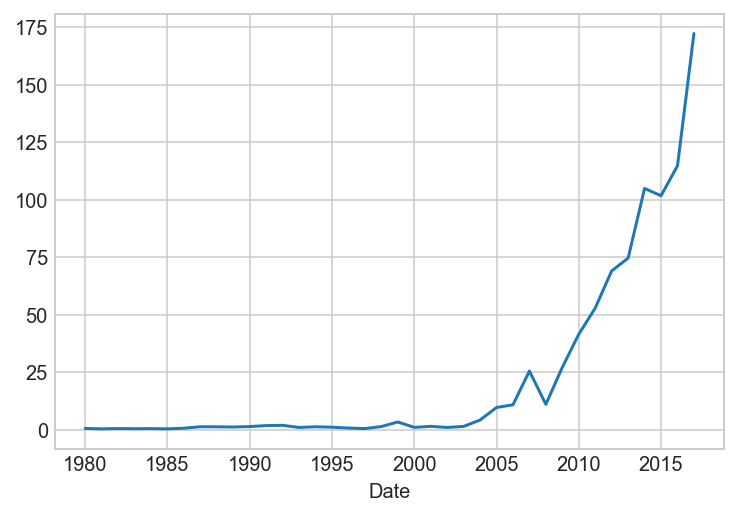

In [40]:
aapl.asfreq("Y", method="bfill")['Adj. Close'].plot()

# Returns

In [60]:
daily_close = aapl['Adj. Close']
daily_pct_change = daily_close.pct_change()

daily_log_returns = np.log(daily_close.pct_change() + 1)

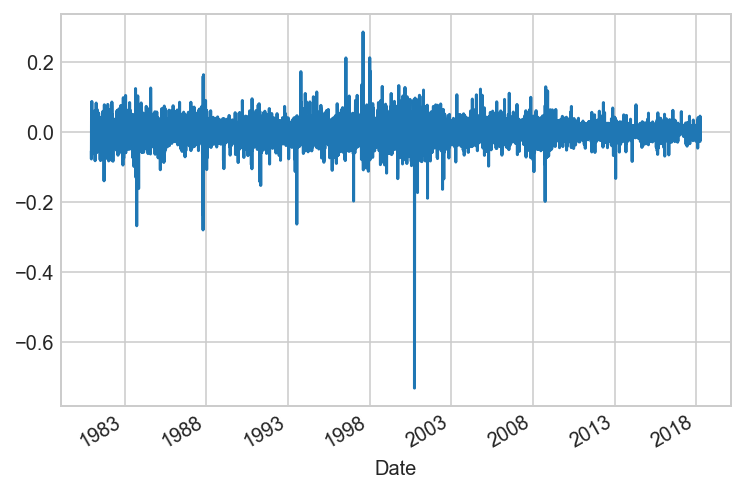

In [51]:
daily_log_returns.plot()

In [52]:
monthly = aapl.resample('BM').apply(lambda x: x[-1])

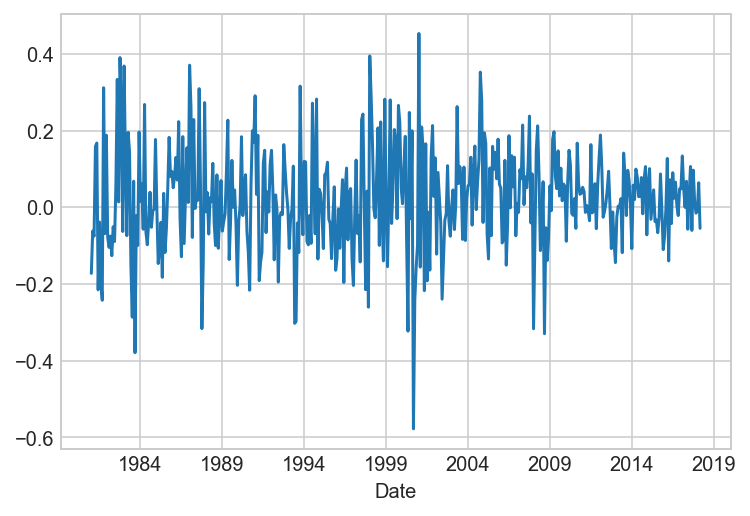

In [53]:
monthly.pct_change()['Adj. Close'].plot()

In [54]:
quarter = aapl.resample("4M").mean()

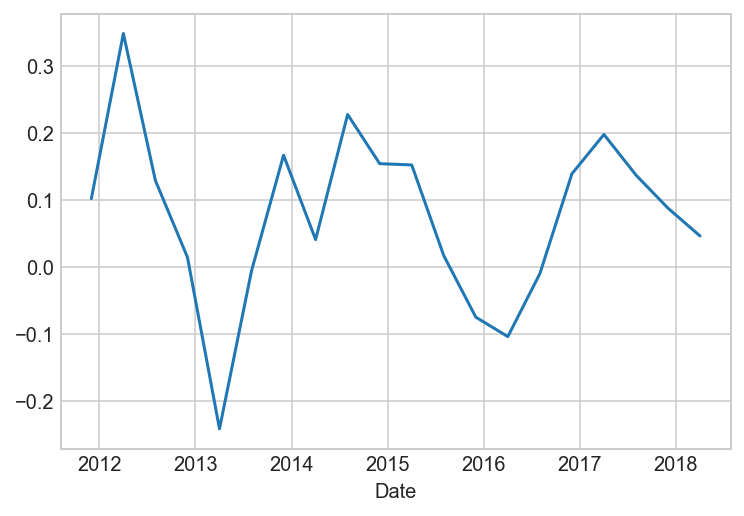

In [55]:
quarter.pct_change()['Adj. Close'].tail(20).plot()

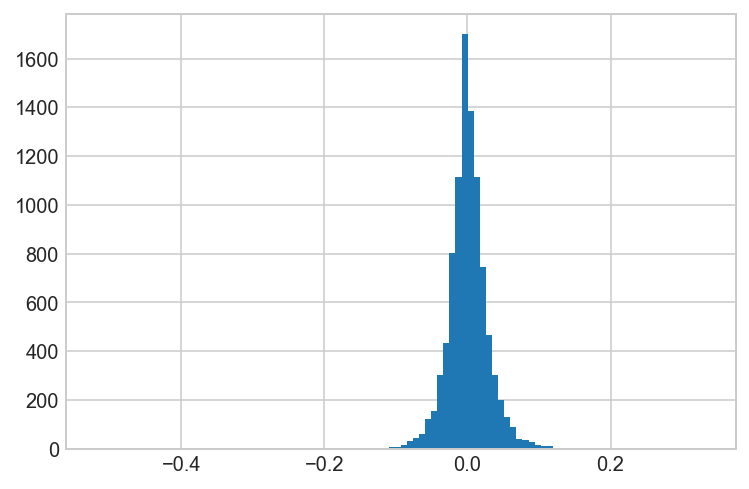

In [56]:
daily_pct_change.hist(bins=100)
plt.show()

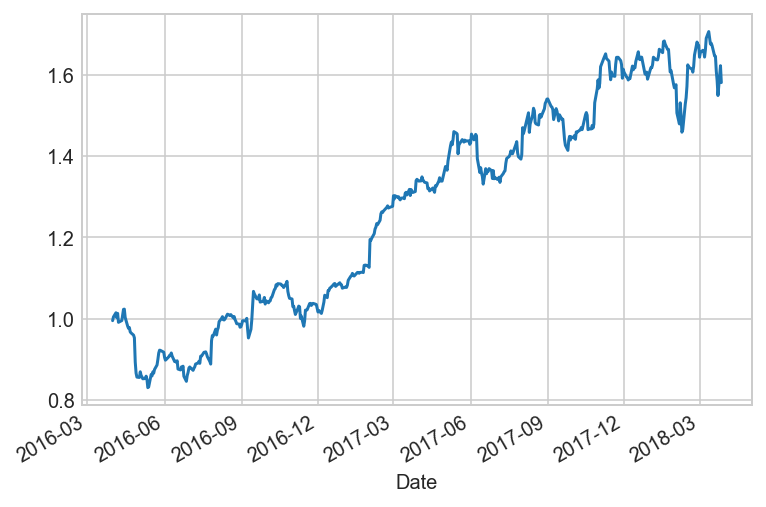

In [57]:
(1 + daily_pct_change).tail(500).cumprod().plot()
plt.show()

In [23]:
tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get_stocks(tickers,
               datetime.datetime(2006, 10, 1),
               datetime.datetime(2012, 1, 1))


In [64]:
daily_close_px = all_data['Adj. Close'].reset_index().pivot('Date',
                                                           'Ticker',
                                                           'Adj. Close')

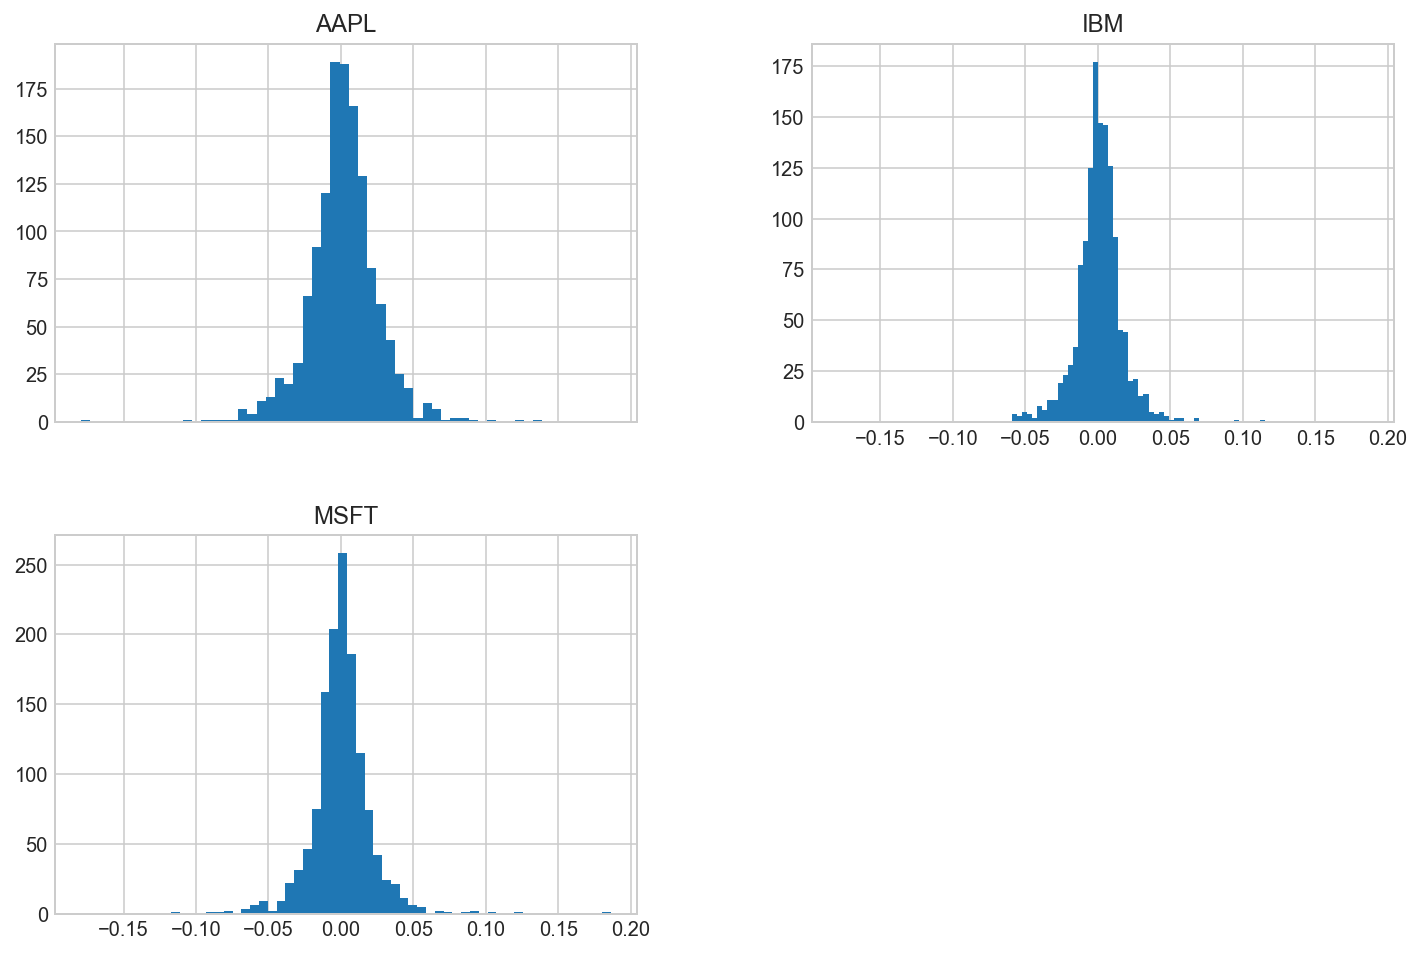

In [25]:
daily_close_px.pct_change().hist(bins=50, sharex=True, figsize=(12, 8))
plt.show()

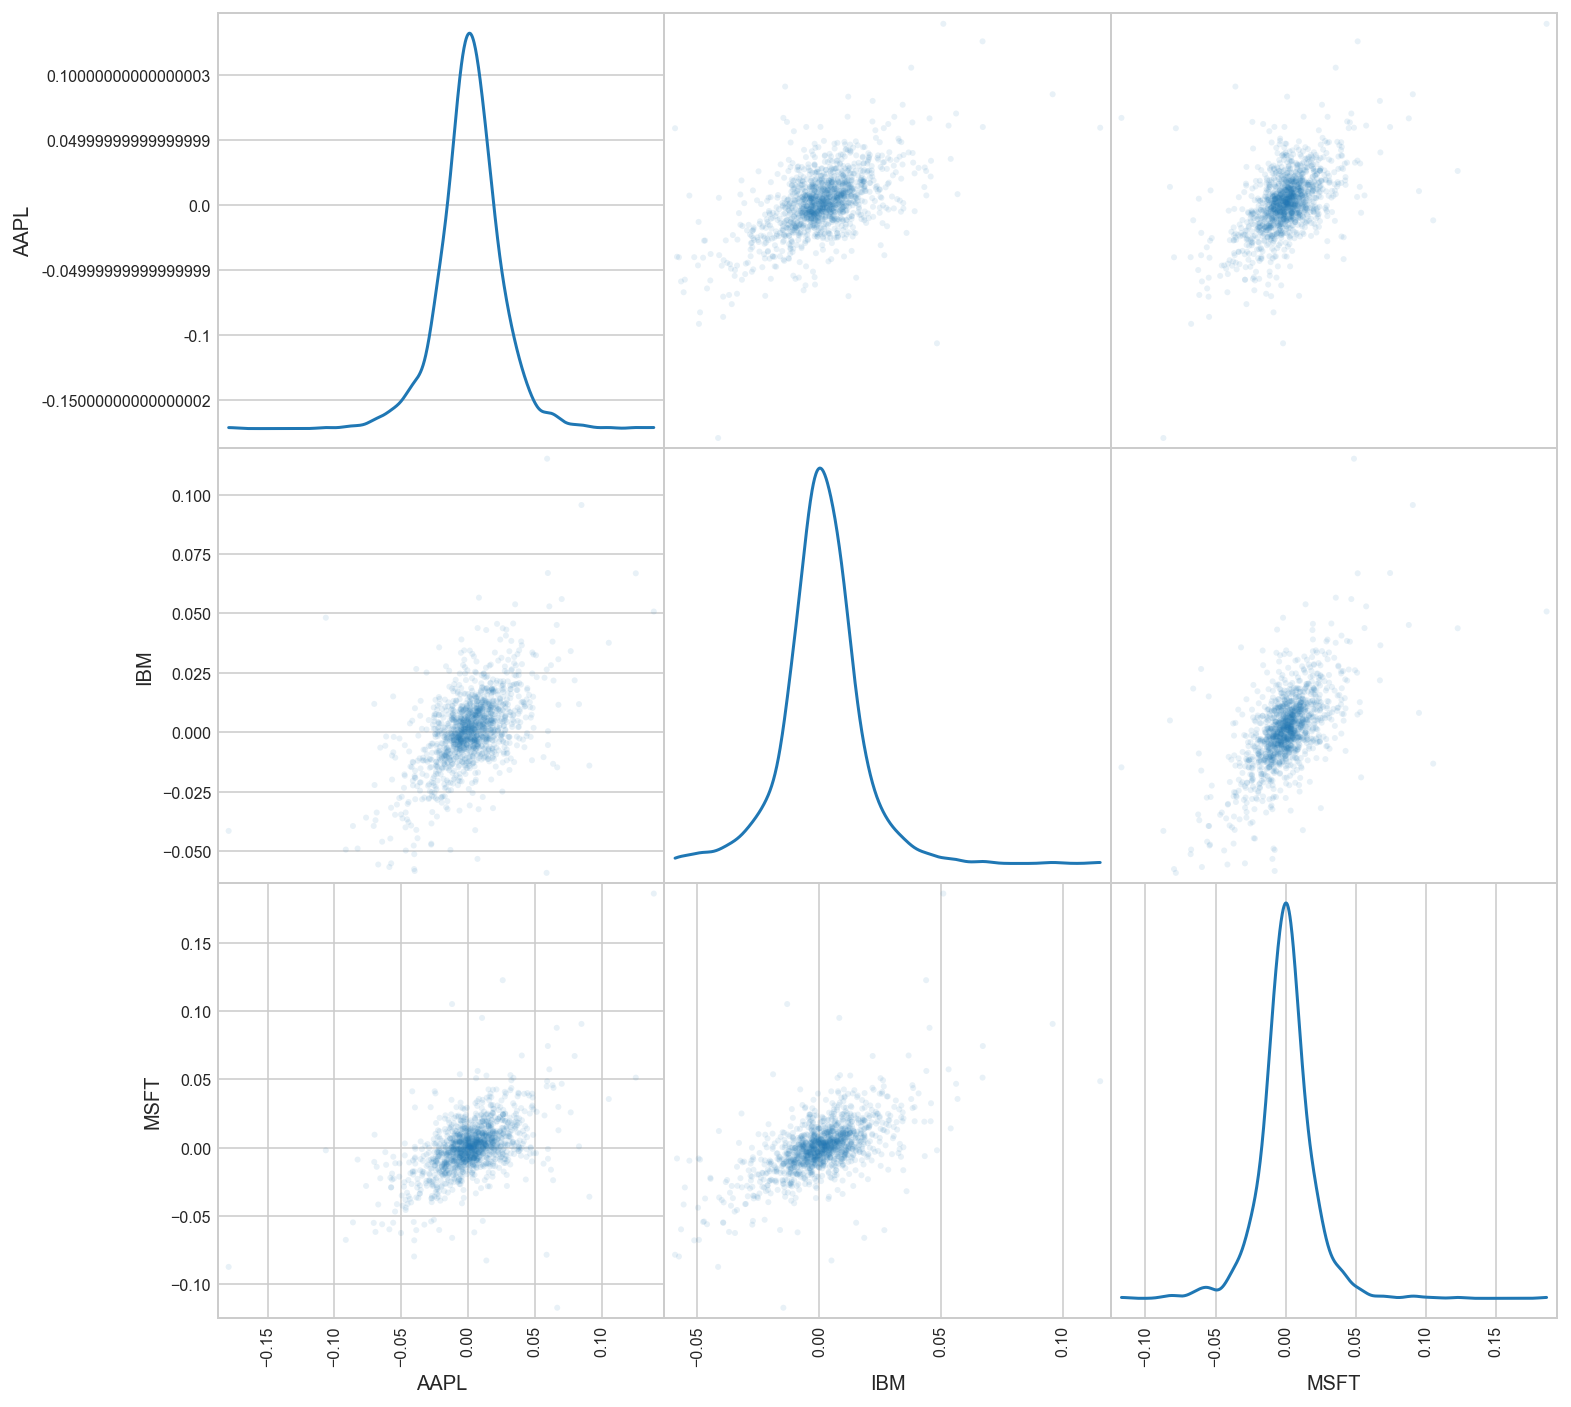

In [133]:
pd.plotting.scatter_matrix(daily_close_px.pct_change(), 
                  diagonal='kde',
                  alpha=0.1,
                  figsize=(12,12))
plt.show()

# Moving Window

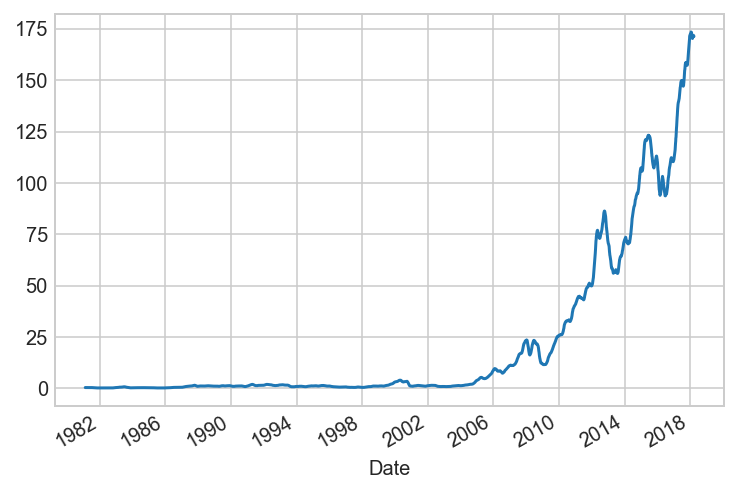

In [32]:
aapl['Adj. Close'].rolling(window=40).mean().plot()

In [34]:
adj_close_px = aapl['Adj. Close']

In [36]:
aapl['42']= aapl['Adj. Close'].rolling(window=40).mean()
aapl['252'] = aapl['Adj. Close'].rolling(window=252).mean()

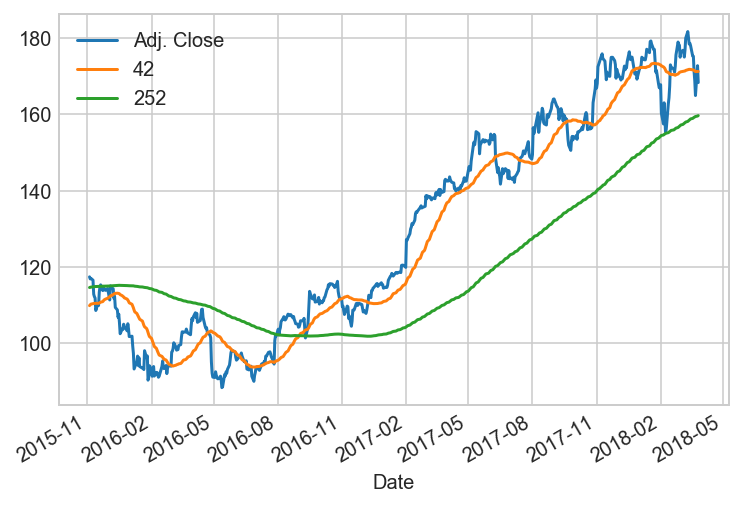

In [41]:
aapl[['Adj. Close', '42', '252']].tail(600).plot()

# Volatility Calculation

In [65]:
daily_pct_change = daily_close_px.pct_change()

In [66]:
vol = daily_pct_change.rolling(min_period).std() * np.sqrt(min_period) 

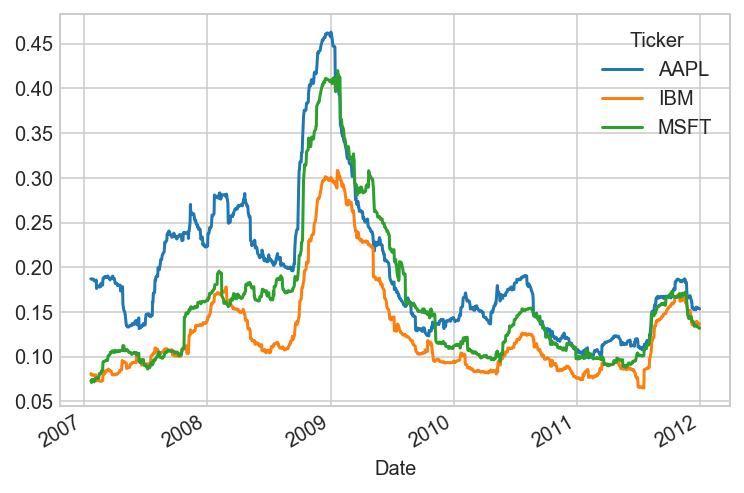

In [67]:
vol.plot()

# Ordinary Least-Squares Regression

In [69]:
import statsmodels.api as sm

In [71]:
all_adj_close = all_data['Adj. Close']

In [72]:
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

In [73]:
# Isolate the AAPL returns 
aapl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'AAPL']
aapl_returns.index = aapl_returns.index.droplevel('Ticker')

# Isolate the MSFT returns
msft_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'MSFT']
msft_returns.index = msft_returns.index.droplevel('Ticker')

In [78]:
return_data = pd.concat([aapl_returns, msft_returns], axis=1)[1:]
return_data.columns = ['AAPL', 'MSFT']

In [83]:
model = sm.OLS(
    return_data['MSFT'],
    sm.add_constant(return_data['AAPL'])).fit()

In [85]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     516.0
Date:                Sat, 21 Jul 2018   Prob (F-statistic):           1.09e-96
Time:                        17:31:08   Log-Likelihood:                 3514.1
No. Observations:                1322   AIC:                            -7024.
Df Residuals:                    1320   BIC:                            -7014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.119      0.2

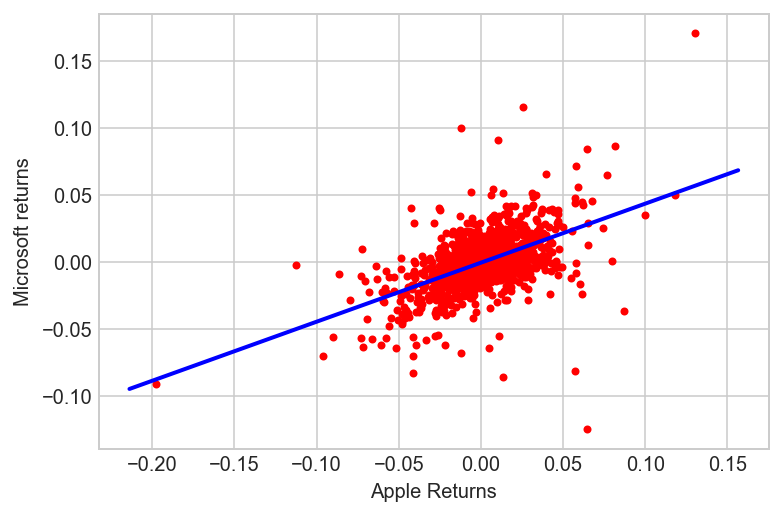

In [86]:
plt.plot(return_data['AAPL'], return_data['MSFT'], 'r.')

# Add an axis to the plot
ax = plt.axis()

# Initialize `x`
x = np.linspace(ax[0], ax[1] + 0.01)

# Plot the regression line
plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

# Customize the plot
plt.grid(True)
plt.axis('tight')
plt.xlabel('Apple Returns')
plt.ylabel('Microsoft returns')

# Show the plot
plt.show()

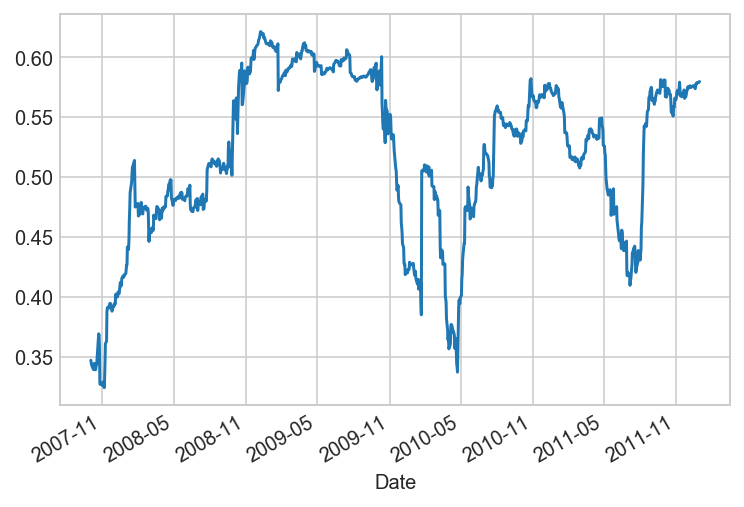

In [87]:
return_data['MSFT'].rolling(window=252).corr(return_data['AAPL']).plot()

# Show the plot
plt.show()

# Simple trading strategy

In [88]:
short_window = 40
long_window = 100

In [89]:
signals = pd.DataFrame(index=aapl.index)

In [91]:
signals['signal'] = 0.0

In [97]:
signals['short_mavg'] = aapl['Close'].rolling(
    window=short_window, min_periods=1, center=False).mean()

In [98]:
signals['long_mavg'] = aapl['Close'].rolling(
    window=long_window, min_periods=1, center=False).mean()

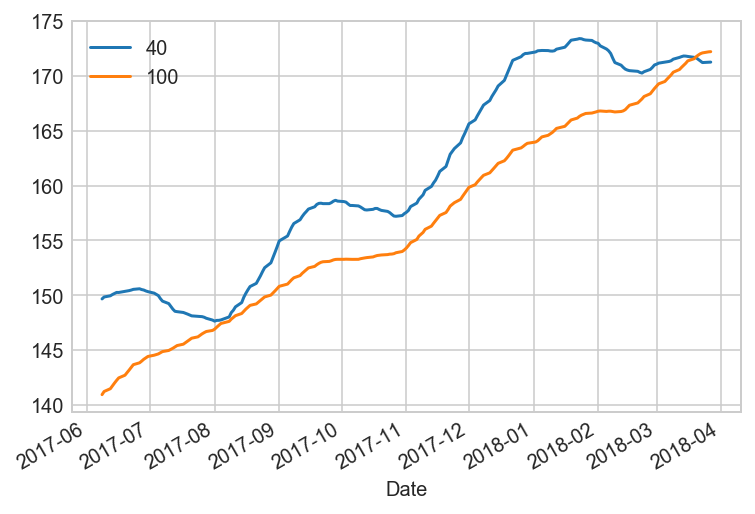

In [107]:
fig, ax = plt.subplots()

signals['short_mavg'].tail(200).plot(ax=ax)
signals['long_mavg'].tail(200).plot(ax=ax)
plt.legend([short_window, long_window])
plt.show()

In [116]:
signals['signal'] = np.where(signals['short_mavg'] > signals['long_mavg'], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

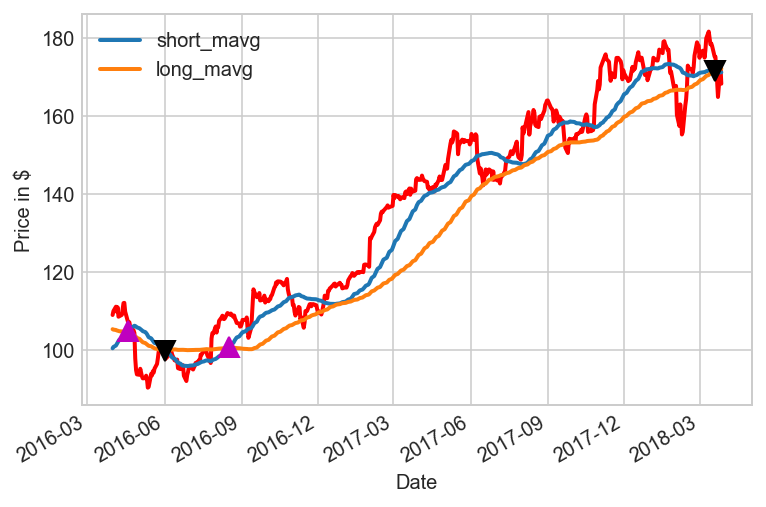

In [132]:
n = 500
df = signals.tail(n)
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].tail(n).plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
df[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(df.loc[signals.positions == 1.0].index, 
         df.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(df.loc[signals.positions == -1.0].index, 
         df.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

# Backtesting

In [5]:
from zipline.api import symbol, order, record

In [6]:
%load_ext zipline

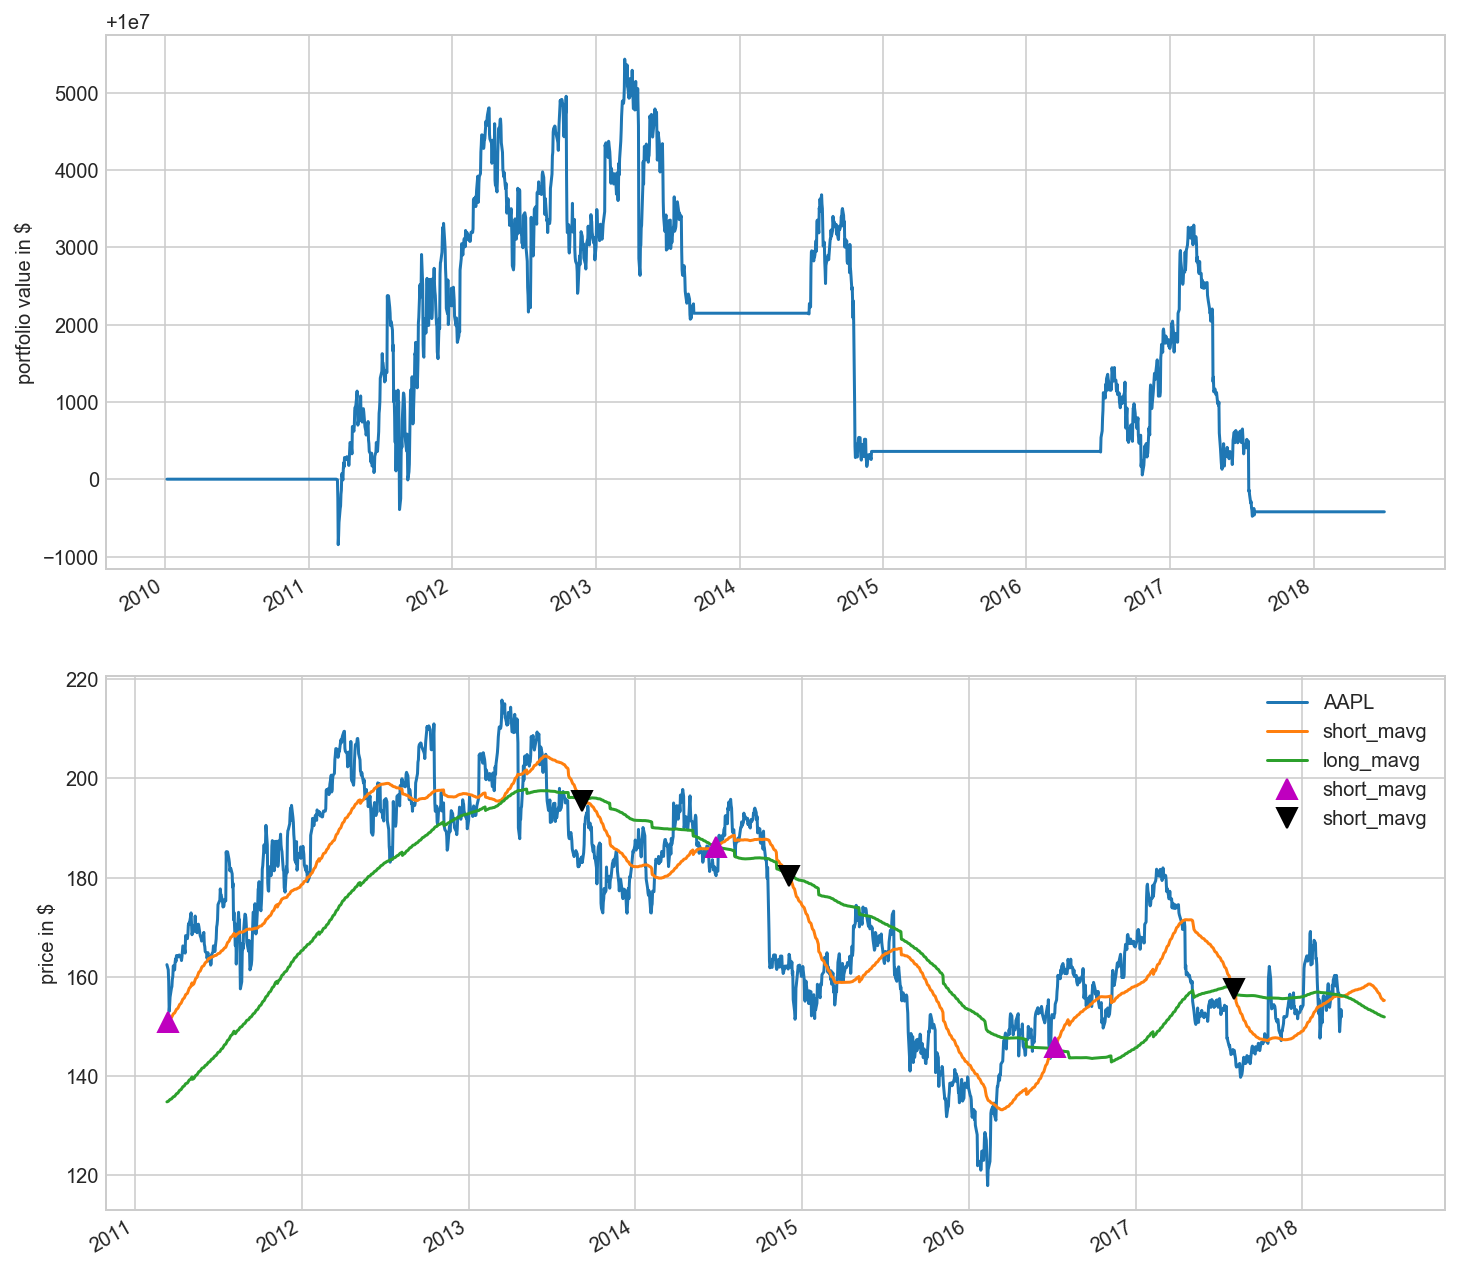

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_mavg,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2010-01-04 21:00:00+00:00,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,1,[],0.0
2010-01-05 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,2,[],0.0
2010-01-06 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,3,[],0.0
2010-01-07 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,4,[],0.0
2010-01-08 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,5,[],0.0
2010-01-11 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,6,[],0.0
2010-01-12 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,7,[],0.0
2010-01-13 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,8,[],0.0
2010-01-14 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,9,[],0.0
2010-01-15 21:00:00+00:00,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,10000000.00,0.0,...,NaN,0.0,0,NaN,10000000.00,0.0,0.0,10,[],0.0


In [11]:
%%zipline --start 2010-1-1 --end 2018-7-1 -o dma.pickle

from zipline.api import order_target, record, symbol
import matplotlib.pyplot as plt

def initialize(context):
    context.i = 0
    context.asset = symbol('IBM')


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=100, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=300, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)


def analyze(context, perf):
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.ix[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.ix[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()


In [8]:
import pickle

In [9]:
portfolio = pickle.load(file('dma.pickle'))

In [10]:
returns = portfolio['returns']
sharpe_ratio = np.sqrt(252)  * (returns.mean() / returns.std())

In [175]:
print(sharpe_ratio)

-0.15385268629104956


In [176]:
window = 252
rolling_max = aapl['Adj. Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Adj. Close'] / rolling_max - 1.0

max_daily_drawdown = daily_dropdown.rolling(window, min_periods=1).min()

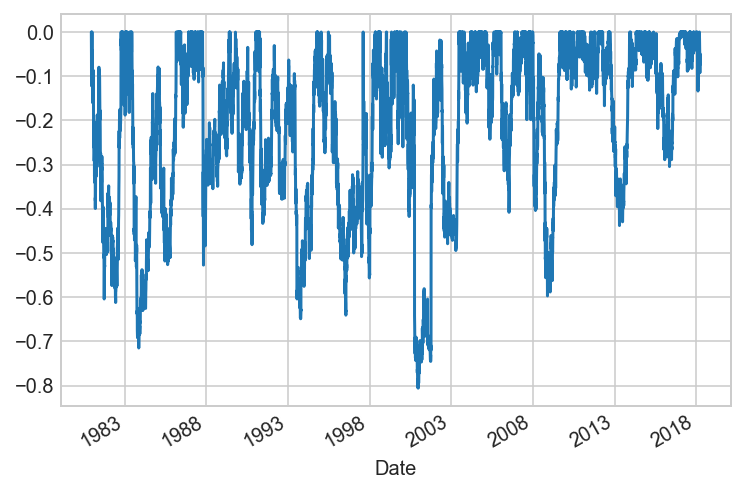

In [177]:
daily_drawdown.plot()

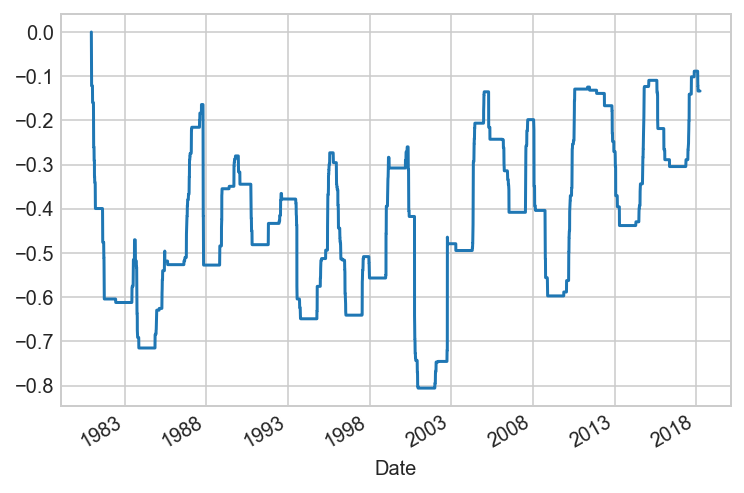

In [178]:
max_daily_drawdown.plot()

In [186]:
import talib

In [194]:
aapl

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,42,252
Date,,,,,,,,,,,,,,
1980-12-12,28.750,28.870,28.7500,28.750,2093900.0,0.0,1.0,0.422706,0.424470,0.422706,0.422706,117258400.0,NaN,NaN
1980-12-15,27.380,27.380,27.2500,27.250,785200.0,0.0,1.0,0.402563,0.402563,0.400652,0.400652,43971200.0,NaN,NaN
1980-12-16,25.370,25.370,25.2500,25.250,472000.0,0.0,1.0,0.373010,0.373010,0.371246,0.371246,26432000.0,NaN,NaN
1980-12-17,25.870,26.000,25.8700,25.870,385900.0,0.0,1.0,0.380362,0.382273,0.380362,0.380362,21610400.0,NaN,NaN
1980-12-18,26.630,26.750,26.6300,26.630,327900.0,0.0,1.0,0.391536,0.393300,0.391536,0.391536,18362400.0,NaN,NaN
1980-12-19,28.250,28.380,28.2500,28.250,217100.0,0.0,1.0,0.415355,0.417266,0.415355,0.415355,12157600.0,NaN,NaN
1980-12-22,29.630,29.750,29.6300,29.630,166800.0,0.0,1.0,0.435644,0.437409,0.435644,0.435644,9340800.0,NaN,NaN
1980-12-23,30.880,31.000,30.8800,30.880,209600.0,0.0,1.0,0.454023,0.455787,0.454023,0.454023,11737600.0,NaN,NaN
1980-12-24,32.500,32.630,32.5000,32.500,214300.0,0.0,1.0,0.477841,0.479753,0.477841,0.477841,12000800.0,NaN,NaN


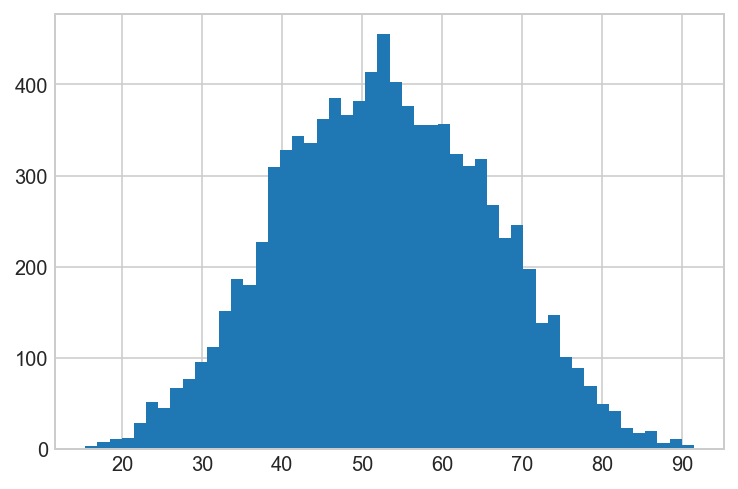

In [200]:
talib.RSI(aapl['Adj. Close']).hist(bins=50)

In [203]:
%%zipline --start 2010-1-1 --end 2018-7-1 -o momentum.pickle

from zipline.api import order, record, symbol
from zipline.finance import commission, slippage
# Import exponential moving average from talib wrapper
from talib import EMA


def initialize(context):
    context.asset = symbol('AAPL')

    # To keep track of whether we invested in the stock or not
    context.invested = False

    # Explicitly set the commission/slippage to the "old" value until we can
    # rebuild example data.
    # github.com/quantopian/zipline/blob/master/tests/resources/
    # rebuild_example_data#L105
    context.set_commission(commission.PerShare(cost=.0075, min_trade_cost=1.0))
    context.set_slippage(slippage.VolumeShareSlippage())


def handle_data(context, data):
    trailing_window = data.history(context.asset, 'price', 40, '1d')
    if trailing_window.isnull().values.any():
        return
    short_ema = EMA(trailing_window.values, timeperiod=20)
    long_ema = EMA(trailing_window.values, timeperiod=40)

    buy = False
    sell = False

    if (short_ema[-1] > long_ema[-1]) and not context.invested:
        order(context.asset, 100)
        context.invested = True
        buy = True
    elif (short_ema[-1] < long_ema[-1]) and context.invested:
        order(context.asset, -100)
        context.invested = False
        sell = True

    record(AAPL=data.current(context.asset, "price"),
           short_ema=short_ema[-1],
           long_ema=long_ema[-1],
           buy=buy,
           sell=sell)


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    results.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('Portfolio value (USD)')

    ax2 = fig.add_subplot(212)
    ax2.set_ylabel('Price (USD)')

    # If data has been record()ed, then plot it.
    # Otherwise, log the fact that no data has been recorded.
    if 'AAPL' in results and 'short_ema' in results and 'long_ema' in results:
        results[['AAPL', 'short_ema', 'long_ema']].plot(ax=ax2)

        ax2.plot(
            results.index[results.buy],
            results.loc[results.buy, 'long_ema'],
            '^',
            markersize=10,
            color='m',
        )
        ax2.plot(
            results.index[results.sell],
            results.loc[results.sell, 'short_ema'],
            'v',
            markersize=10,
            color='k',
        )
        plt.legend(loc=0)
        plt.gcf().set_size_inches(18, 8)
    else:
        msg = 'AAPL, short_ema and long_ema data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    plt.show()


TypeError: super(type, obj): obj must be an instance or subtype of type

In [187]:
portfolio = pickle.load(file('momentum.pickle'))

returns = portfolio['returns']
sharpe_ratio = np.sqrt(252)  * (returns.mean() / returns.std())

In [188]:
sharpe_ratio


0.7020968204108198